# Recon artifact debugging.

Play with the gradient and understand where the artifact is showing up

In [1]:
# % matplotlib widget # turn on for interactive plotting
# % matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import sdc_config5 as sdc
import torchvision
import os
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
gpu = 2
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# torch.cuda.set_device(gpu)
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")# device = torch.device("cpu")

# Import calibration data

806


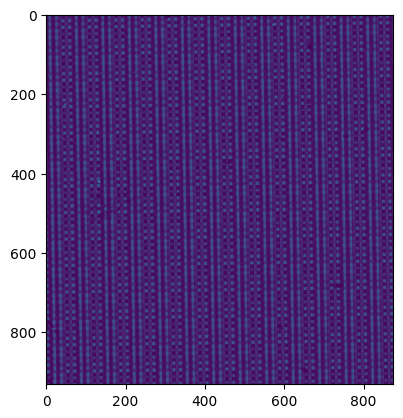

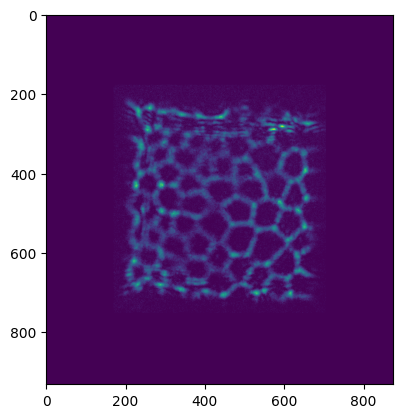

In [2]:
# load relevant files
calibration_location = 'recon_materials_organized'
psf_name = 'psf_2024-01-30.pt'
calibration_wavelengths_file = 'connie_cal_waves.pt'
filter_cube_file = 'connie_normalized_filter_cube.pt'
datafolder = '/media/azuldata/neerja/2024-01-30/drying_beads_30umgreenorange/'
ground_truth_spectra_locs = ['/media/azuldata/neerja/2022-04-08/greenbeads_oldslide_emissionspectra.csv', 
                            '/media/azuldata/neerja/2022-04-08/redbeads_fresh_emissionspectra.csv']
bits = 16
# crop_indices = [500,1750,1000,2900] #top bottom left default: [320,1652,1350,2726]
crop_indices = [720,1652,1650,2526] #top bottom left default: [320,1652,1350,2726]
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
sample = datafolder.split('/')[-1]
kmax = 5000
step_size = 1e-1
thr = 6e-6 #3e-6
xytv = 1e-4 #1e-4
lamtv = 2e-5 #2e-6
kprint = 100
dict_learn = False

# Load wavelength calibration and downsample to spectral resolution of filter cube
wv = torch.load(os.path.join(calibration_location, calibration_wavelengths_file),map_location='cpu')
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

# Load and crop filter cube
normalized_filter_cube = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
filterstack = sdc.cropci(normalized_filter_cube, crop_indices)
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)

# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:])
psf = ccrop(sensor_psf)
psf = psf/torch.sum(psf)
psf = psf.clip(0)

plt.figure()
# plt.figure(figsize = (10,10))
plt.imshow(torch.sum(spectral_filter,dim=0))
# plt.figure(figsize = (10,10))
plt.figure()
plt.imshow(psf)
plt.show()

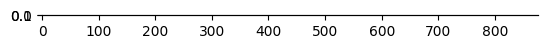

In [14]:
plt.plot(spectral_filter[:,200,200])
plt.ylim([0,.1])

mask_min, mask_min_ind = torch.min(spectral_filter, dim = 0)


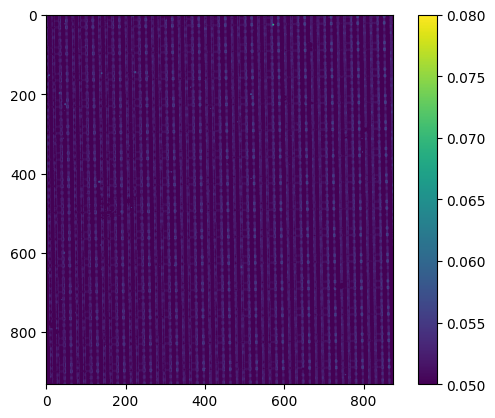

In [20]:
mask_min.shape
plt.imshow(mask_min.numpy())
plt.colorbar()
plt.clim([0.05,0.08])


# Check PSF autocorrelation

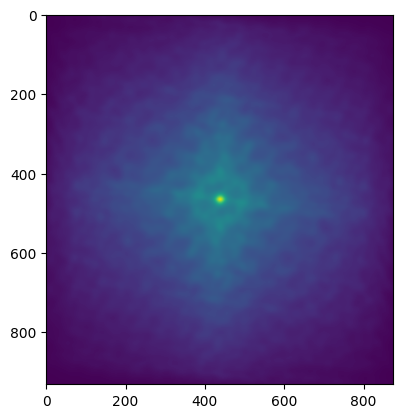

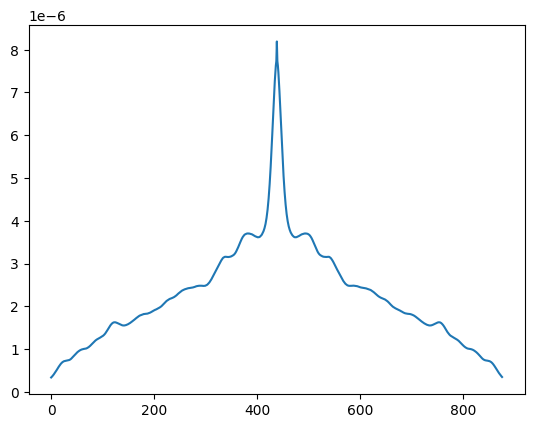

In [9]:
from scipy.signal import correlate
psf_corr = correlate(psf,psf, mode = 'same')
plt.figure()
plt.imshow(psf_corr)
plt.show()

plt.figure()

ny,nx = psf_corr.shape
plt.plot(psf_corr[int(ny/2),:])
plt.show()

# Try Binning

In [10]:
import numpy as np

def bin_image(image, bin_factor):
    """
    Bins an image by the specified factor. The input image is assumed to be a numpy array.
    
    Parameters:
    - image: numpy array of the image.
    - bin_factor: the factor by which to bin the image (e.g., 2 for 2x2 binning).
    
    Returns:
    - Binned image as a numpy array.
    """
    # Check if image dimensions are divisible by bin_factor
    if image.shape[0] % bin_factor != 0 or image.shape[1] % bin_factor != 0:
        raise ValueError("Image dimensions must be divisible by bin_factor")
    
    # Reshape the image to prepare for binning
    shape = (image.shape[0] // bin_factor, bin_factor,
             image.shape[1] // bin_factor, bin_factor)
    # Perform the binning (mean over the bins)
    binned_image = image.reshape(shape).mean(-1).mean(1)
    
    return binned_image

# Example usage:
# Assuming `image` is your input numpy array representing the image
# bin_factor = 2  # Example binning factor
# binned_image = bin_image(image, bin_factor)


In [11]:
print(range(43))

range(0, 43)


In [12]:
bin_factor = 4
psf_bin = bin_image(psf, bin_factor)
nw,ny,nx = spectral_filter.shape
spectral_filter_bin = np.zeros([nw,int(ny/bin_factor), int(nx/bin_factor)])
for k in range(spectral_filter.shape[0]):
    spectral_filter_bin[k,:,:] = bin_image(spectral_filter[k,:,:],bin_factor)


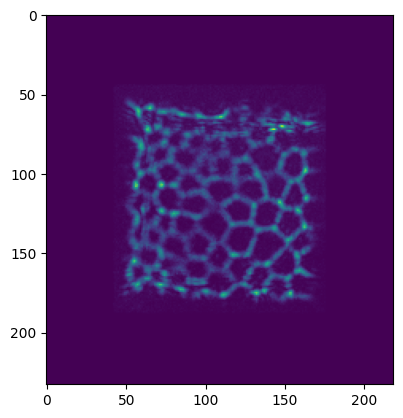

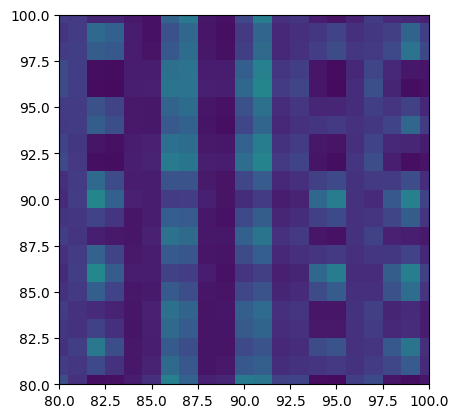

In [13]:
plt.figure()
plt.imshow(psf_bin)

plt.figure()
# plt.figure(figsize = (10,10))
plt.imshow(np.sum(spectral_filter_bin,axis=0))
plt.xlim([80,100])
plt.ylim([80,100])
plt.show()



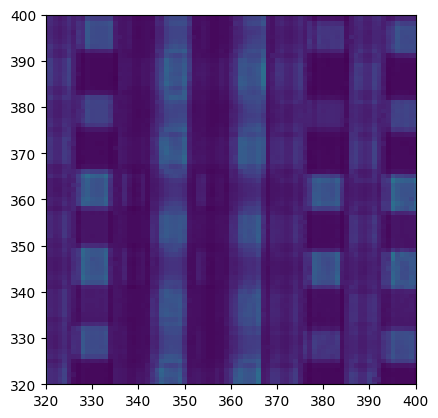

In [14]:

plt.figure()
# plt.figure(figsize = (10,10))
plt.imshow(torch.sum(spectral_filter,axis=0))
plt.xlim([80*bin_factor,100*bin_factor])
plt.ylim([80*bin_factor,100*bin_factor])
plt.show()

(0.0, 0.15)

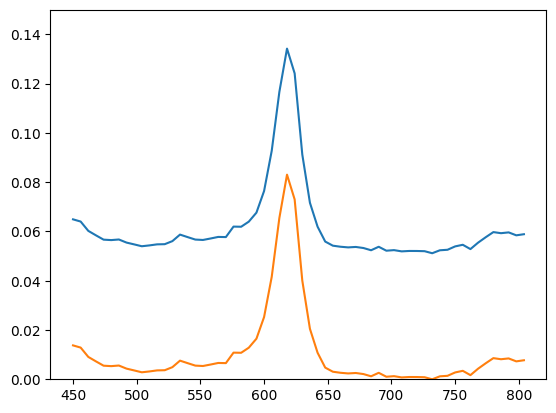

In [21]:
spectrum = spectral_filter[:,90*bin_factor, 90*bin_factor]
spectrum_offset = spectrum - torch.amin(spectrum)
plt.figure()
plt.plot(wavelengths,spectrum)
plt.plot(wavelengths,spectrum_offset)
plt.ylim([0,0.15])